# Modelos Econométricos
Neste notebook tem os seguintes modelos estatísticos:
- AR
- ARIMA
- SARIMA

## Importações

In [1]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# statsmodels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# autoarima
import pmdarima as pm

# Other
from IPython.display import Image
import warnings
import pprint
import datetime
import itertools
import os

## Preparação do Diretório Principal

In [2]:
def prepare_directory_work(end_directory: str='notebooks'):
    # Current path
    curr_dir = os.path.dirname(os.path.realpath("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}' 

In [3]:
prepare_directory_work(end_directory='notebooks')

'/home/campos/projects/tcc-ufsc-grad/notebooks'

## Formatação das células

In [4]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# Guarantees visualization inside the jupyter
%matplotlib inline

# Print xxxx rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# pretty print
pp = pprint.PrettyPrinter(indent=4)

In [5]:
plt.style.use('seaborn')  # fivethirtyeight
plt.rc('figure',figsize=(16,8))
plt.rc('font',size=15)
plt.rc('legend',fontsize=15)

# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set(style='dark', palette='deep')

plt.style.use('fivethirtyeight')

## Carregamento dos dados

In [6]:
%%time

df_vale3 = pd.read_csv('data/cleansing/df_vale3_cleansing.csv',
                              encoding='utf8',
                              delimiter=',',
                              parse_dates=True,
                              index_col=0,
                              verbose=True)

Tokenization took: 2.94 ms
Type conversion took: 3.39 ms
Parser memory cleanup took: 0.01 ms
CPU times: user 15.2 ms, sys: 1.52 ms, total: 16.7 ms
Wall time: 15.2 ms


In [7]:
df_vale3.head()

,preco,residuos,tendencia,sazonalidade,diff_1,diff_2,diff_3,diff_4,diff_5
data,,,,,,,,,
2010-07-12,40.000000,1.002310,41.827333,1.000149,-0.600000,-0.460000,0.490000,0.980000,0.420000
2010-07-13,40.070000,1.036654,41.910833,0.998563,0.070000,-0.530000,-0.390000,0.560000,1.050000
2010-07-14,40.080000,1.028377,41.977833,1.000439,0.010000,0.080000,-0.520000,-0.380000,0.570000
2010-07-15,39.760000,1.044658,42.045833,1.000935,-0.320000,-0.310000,-0.240000,-0.840000,-0.700000
2010-07-16,38.880000,1.028132,42.123500,1.001784,-0.880000,-1.200000,-1.190000,-1.120000,-1.720000


---

## Divisão dos Dados

In [8]:
size_train = 2132
size_test = 313
print(size_train)
print(size_test)

df_train = df_vale3['preco'].iloc[:size_train]
df_test = df_vale3['preco'].iloc[size_train:]

2132
313


In [9]:
df_train.tail()

data
2019-02-15   45.880000
2019-02-18   45.250000
2019-02-19   45.490000
2019-02-20   45.800000
2019-02-21   45.380000
Name: preco, dtype: float64

Text(0.5, 1.0, 'Tamaho Treinamento = 2132')

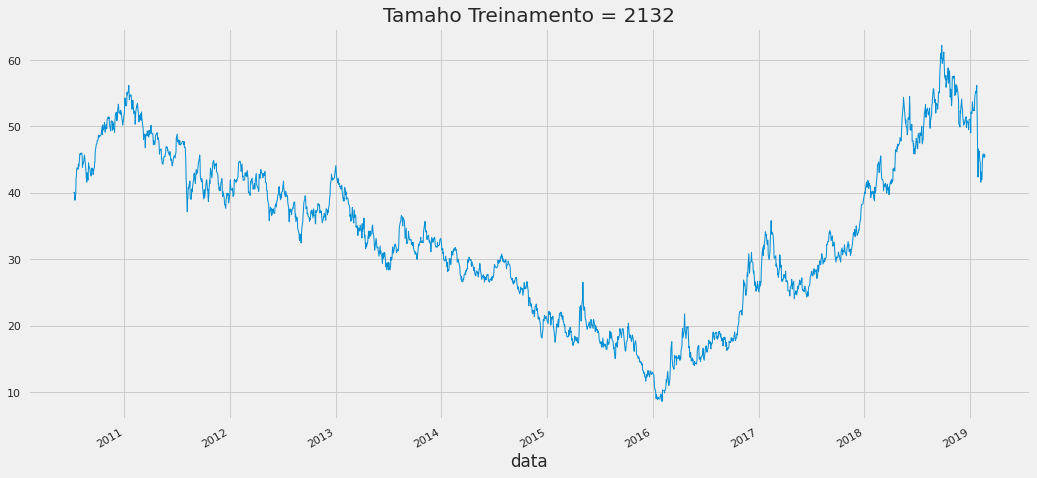

In [10]:
df_train.plot(linewidth=1)
plt.grid(True)
plt.title(f'Tamaho Treinamento = {len(df_train)}')

In [11]:
df_test.head()

data
2019-02-22   46.990000
2019-02-25   47.120000
2019-02-26   47.200000
2019-02-27   46.830000
2019-02-28   47.100000
Name: preco, dtype: float64

Text(0.5, 1.0, 'Tamaho Teste = 313')

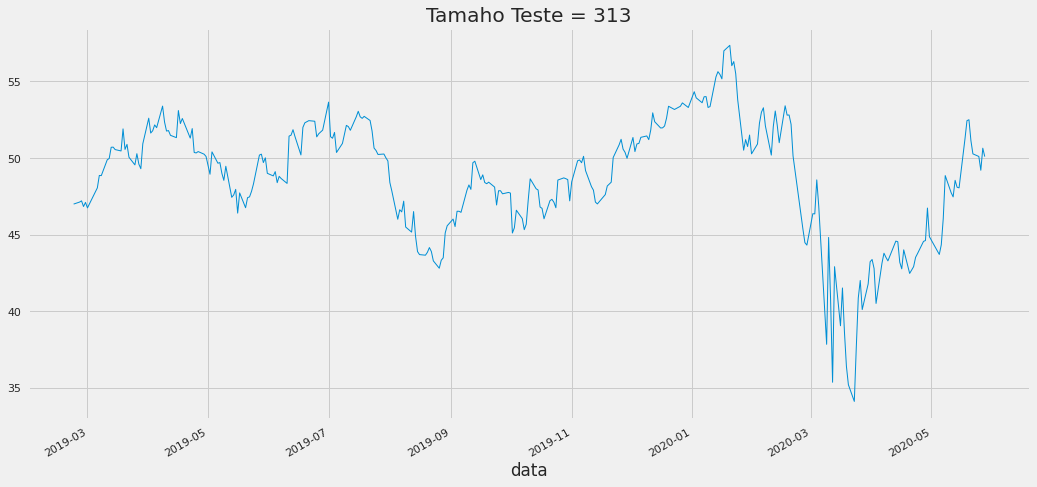

In [12]:
df_test.plot(linewidth=1)
plt.grid(True)
plt.title(f'Tamaho Teste = {len(df_test)}')

### Manipulação do índice

In [13]:
df_train.index

DatetimeIndex(['2010-07-12', '2010-07-13', '2010-07-14', '2010-07-15',
               '2010-07-16', '2010-07-19', '2010-07-20', '2010-07-21',
               '2010-07-22', '2010-07-23',
               ...
               '2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-18', '2019-02-19',
               '2019-02-20', '2019-02-21'],
              dtype='datetime64[ns]', name='data', length=2132, freq=None)

In [14]:
df_test.index

DatetimeIndex(['2019-02-22', '2019-02-25', '2019-02-26', '2019-02-27',
               '2019-02-28', '2019-03-01', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-11',
               ...
               '2020-05-15', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22', '2020-05-25', '2020-05-26',
               '2020-05-27', '2020-05-28'],
              dtype='datetime64[ns]', name='data', length=313, freq=None)

In [15]:
df_train.reset_index(drop=True, inplace=True)
df_train.index

RangeIndex(start=0, stop=2132, step=1)

In [16]:
df_test.reset_index(drop=True, inplace=True)
df_test.index

RangeIndex(start=0, stop=313, step=1)

In [17]:
df_train.index = pd.RangeIndex(start=0, stop=len(df_train), step=1)
df_train.index

RangeIndex(start=0, stop=2132, step=1)

In [18]:
df_test.index = pd.RangeIndex(start=2132, stop=len(df_vale3), step=1)
df_test.index

RangeIndex(start=2132, stop=2445, step=1)

---

## Dicionário de Resultados

In [19]:
dict_results = {}

---

## Impressão dos Resutados

In [20]:
def show_result_model(df_train, df_test, y_forecast, model_name):
    future_forecast = pd.DataFrame(y_forecast,
                                   index=df_test.index,
                                   columns=['previsao'])
    #mape = mean_absolute_percentage_error(df_test, y_forecast)
    mape = mean_absolute_percentage_error(df_test, y_forecast)*100
    
    mse = mean_squared_error(df_test, y_forecast, squared=True)
    dict_results[model_name] = [mape, mse]
    
    pd.concat([df_test, future_forecast], axis=1).plot()

    plt.legend()
    plt.grid(True)
    plt.xlabel("Tempo (dias)", fontsize=20)
    plt.ylabel("Preço (R$)", fontsize=20)
    plt.title(f'MAPE = {mape:.2f} % | MSE = {mse:.2f}', fontsize=25)

---

## Busca dos Melhores Parâmetros

#### Grid Search

In [21]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(0, 3)

# Generate all different combinations of p, q and q triplets
list_pdq = list(itertools.product(p, d, q))
print(f'All different combinations of p, q and q:\n {list_pdq}')

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(f'\n\nAll different combinations of seasonal p, q and q:\n {seasonal_pdq}')

All different combinations of p, q and q:
 [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]


All different combinations of seasonal p, q and q:
 [(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (1, 2, 0, 12), (1, 2, 1, 12), (1, 2, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12), (2, 2, 0, 12), (2, 2, 1, 12), (2, 2, 2, 12)]


In [22]:
def search_best_params_arima_model(df_train: 'Dataframe', pdq: list) -> list:
    best_model = 99999
    best_params = (0, 0, 0)
    param = ()
    
    for param in pdq:
        try:
            arima_model = ARIMA(df_train, order=param)
            results = arima_model.fit()
            print(f'pdq = {param} | AIC = {results.aic}')
            
            if results.aic < best_model:
                best_model = results.aic
                best_params = param
        except: 
            continue
    
    print(f'best ARIMA: {best_params} | AIC:{best_model}')
    return [best_params, best_model]

In [23]:
def search_best_params_sarima_model(df_train, trend, pdq):  
    best_model = 99999
    best_param_seasonal = ()
    param = ()
    param_seasonal = ()
    
    for param_seasonal in seasonal_pdq:
        try:
            sarima_model = SARIMAX(df_train,
                                   order=pdq,
                                   seasonal_order=param_seasonal,
                                   trend=trend,          
                                   enforce_stationarity=True,
                                   enforce_invertibility=False)
            results = sarima_model.fit()
            print(f'pdq = {pdq} | param_seasonal = {param_seasonal} | AIC = {results.aic}')

            if results.aic < best_model:
                best_model = results.aic
                best_param_seasonal = param_seasonal
        except: 
            continue
    
    print(f'\n\nBest SARIMA: {pdq}x{param_seasonal}12 | AIC:{best_model}')
    return [best_param_seasonal, best_model]

---

## **Modelos Estatísticos**

## AR
- A ST não é estacionária
- Não há tendência, (trend='n')
- Não aá sazonalidade, (seasonal=False) no período de 30 dias

In [24]:
ar_model = AutoReg(df_train,
                   lags=313,
                   trend='n',
                   seasonal=False,
                   period=len(df_test))
ar_fit = ar_model.fit()

In [25]:
# forecast
y_ar_forecast = ar_fit.predict(start=(df_test.index[0]), end=df_test.index[-1])

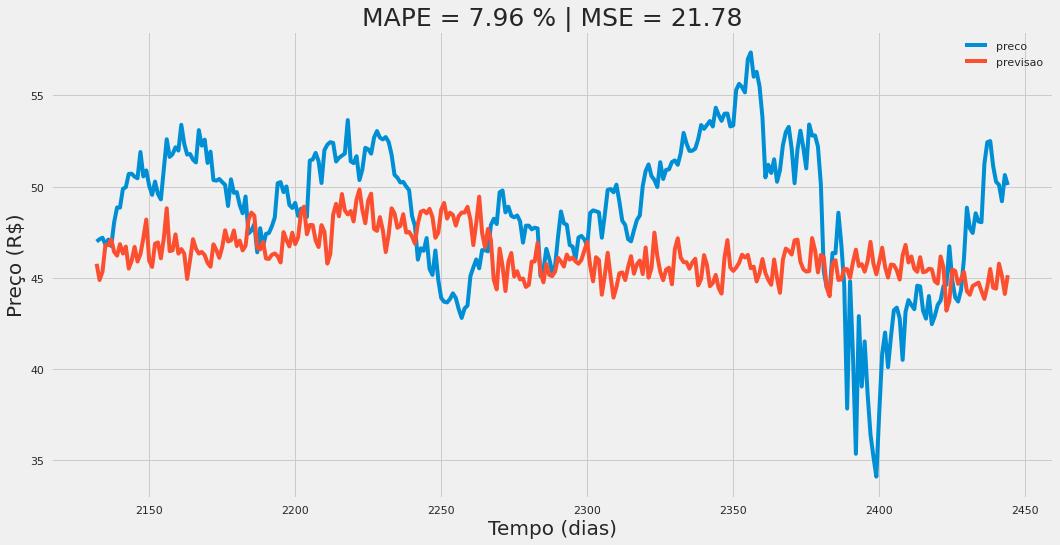

In [26]:
show_result_model(df_train=df_train,
                  df_test=df_test, 
                  y_forecast=y_ar_forecast,
                  model_name='ar_model')

#### zoom

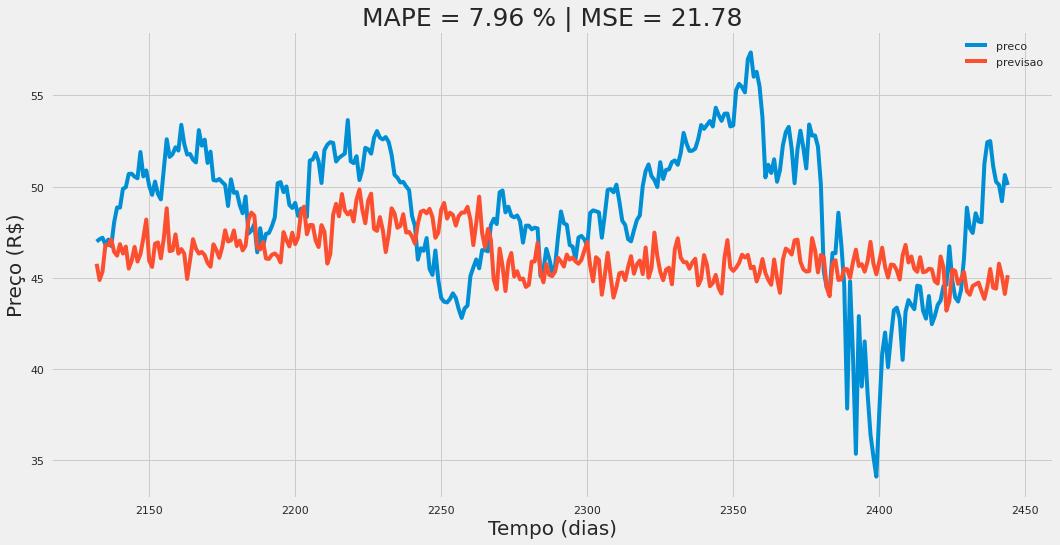

In [27]:
show_result_model(df_train=df_test,
                  df_test=df_test, 
                  y_forecast=y_ar_forecast,
                  model_name='ar_model')

---

### ARIMA

## Librarie: `pmdarima`
- Tips: https://alkaline-ml.com/pmdarima/tips_and_tricks.html

In [28]:
%%time

list_order_arima = search_best_params_arima_model(df_train=df_train,
                                                  pdq=list_pdq)
print(list_order_arima)

pdq = (0, 0, 0) | AIC = 16618.529921052803
pdq = (0, 0, 1) | AIC = 13847.15668983633
pdq = (0, 1, 0) | AIC = 5202.4005815196615
pdq = (0, 1, 1) | AIC = 5202.427062935278
pdq = (0, 1, 2) | AIC = 5190.195445269178
pdq = (0, 2, 0) | AIC = 6616.986469503832
pdq = (0, 2, 1) | AIC = 5209.942045808245
pdq = (0, 2, 2) | AIC = 5209.948411382415
pdq = (1, 0, 0) | AIC = 5209.139906527847
pdq = (1, 0, 1) | AIC = 5209.001459488028
pdq = (1, 0, 2) | AIC = 5197.200090236441
pdq = (1, 1, 0) | AIC = 5202.743560213121
pdq = (1, 1, 1) | AIC = 5195.7933811977655
pdq = (1, 1, 2) | AIC = 5191.786433609438
pdq = (1, 2, 0) | AIC = 6150.321210862042
pdq = (1, 2, 2) | AIC = 5203.335114958441
pdq = (2, 0, 0) | AIC = 5209.340449357725
pdq = (2, 0, 1) | AIC = 5202.394724547465
pdq = (2, 0, 2) | AIC = 5198.922147313669
pdq = (2, 1, 0) | AIC = 5190.807259240531
pdq = (2, 1, 1) | AIC = 5192.782074290211
pdq = (2, 1, 2) | AIC = 5189.626133250238
pdq = (2, 2, 0) | AIC = 5852.928438526969
pdq = (2, 2, 1) | AIC = 5198.37

In [33]:
%%time

autoarima_model = pm.auto_arima(df_train,
                                stepwise=True,
                                suppress_warnings=True,
                                error_action="ignore",
                                information_criterion='aic',
                                start_p=2,
                                start_d=1,
                                start_q=2,
                                lags=313,
                                seasonal=False,
                                trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5189.626, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5202.401, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5202.744, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5202.427, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5200.421, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5191.786, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5192.782, Time=0.56 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5191.420, Time=1.94 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5191.381, Time=2.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5195.793, Time=0.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5189.941, Time=2.74 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5194.800, Time=0.66 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5193.582, Time=1.96 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5187.657, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [34]:
print(autoarima_model.order)
print(autoarima_model.aic())

(2, 1, 2)
5187.656935415547


In [36]:
# fit
autoarima_model_fit = autoarima_model.fit(y=df_train)
autoarima_model_fit

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [37]:
# forecast
y_forecast = autoarima_model_fit.predict(n_periods=len(df_test[:313]))
len(y_forecast)

313

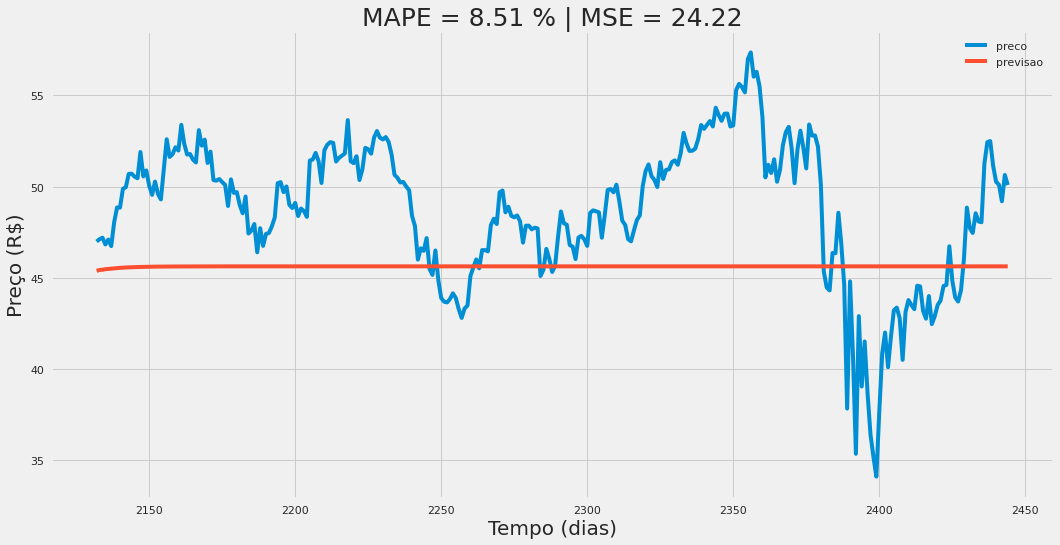

In [39]:
show_result_model(df_train=df_train,
                  df_test=df_test,
                  y_forecast=y_forecast,
                  model_name='arima_model')

#### Zoom

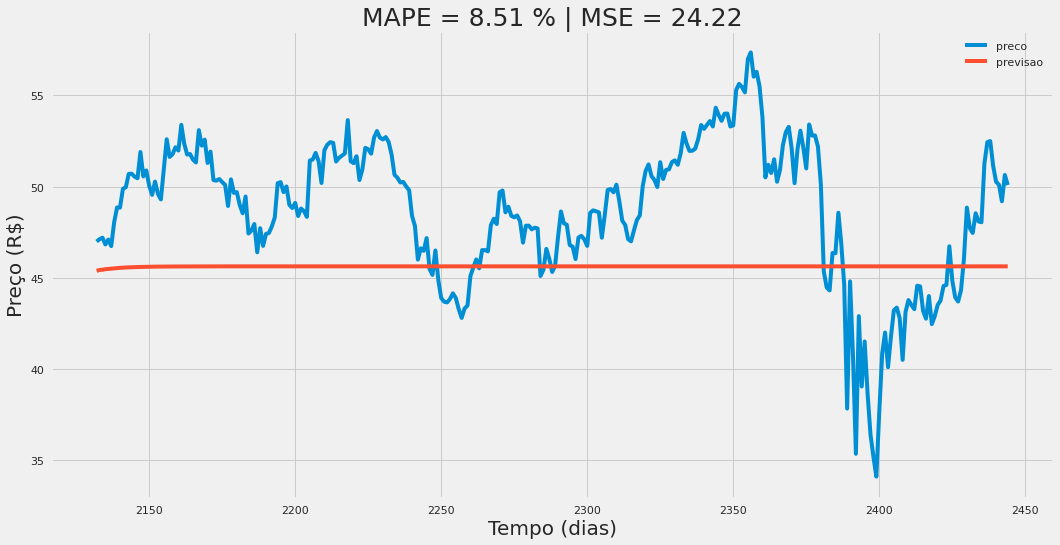

In [40]:
show_result_model(df_train=df_test,
                  df_test=df_test, 
                  y_forecast=y_forecast,
                  model_name='arima_model')

---

## **SARIMA**

In [49]:
%%time

list_order_seasonal_aic = search_best_params_sarima_model(df_train=df_train,
                                                          trend='t',
                                                          pdq=(2, 1, 2))
print(list_order_seasonal_aic)

pdq = (2, 1, 2) | param_seasonal = (0, 0, 0, 12) | AIC = 5191.5422018697
pdq = (2, 1, 2) | param_seasonal = (0, 0, 1, 12) | AIC = 5191.568584251327
pdq = (2, 1, 2) | param_seasonal = (0, 0, 2, 12) | AIC = 5191.023297688418
pdq = (2, 1, 2) | param_seasonal = (0, 1, 0, 12) | AIC = 6669.048884663625
pdq = (2, 1, 2) | param_seasonal = (0, 1, 1, 12) | AIC = 6018.448897661481
pdq = (2, 1, 2) | param_seasonal = (0, 1, 2, 12) | AIC = 7730.417661667607
pdq = (2, 1, 2) | param_seasonal = (0, 2, 0, 12) | AIC = 8901.911156543076
pdq = (2, 1, 2) | param_seasonal = (0, 2, 1, 12) | AIC = 8225.333911230264
pdq = (2, 1, 2) | param_seasonal = (0, 2, 2, 12) | AIC = 7669.739406840514
pdq = (2, 1, 2) | param_seasonal = (1, 0, 0, 12) | AIC = 5191.430740851928
pdq = (2, 1, 2) | param_seasonal = (1, 0, 1, 12) | AIC = 5194.0387448148795
pdq = (2, 1, 2) | param_seasonal = (1, 0, 2, 12) | AIC = 5193.801789566946
pdq = (2, 1, 2) | param_seasonal = (1, 1, 0, 12) | AIC = 6126.856861312977
pdq = (2, 1, 2) | param_se

In [50]:
list_order_seasonal_aic

[(2, 0, 0, 12), 5190.676621773375]

In [52]:
sarima_model = SARIMAX(df_train,
                       order=(2, 1, 2),
                       seasonal_order=list_order_seasonal_aic[0],
                       trend='c',          
                       enforce_stationarity=False,
                       enforce_invertibility=False)

In [53]:
# fit
sarima_fit = sarima_model.fit()
print(sarima_fit)

In [54]:
# forecast
y_forecast_sarima = sarima_fit.predict(start=df_test.index[0], end=df_test.index[-1]).to_numpy()
len(y_forecast_sarima)

313

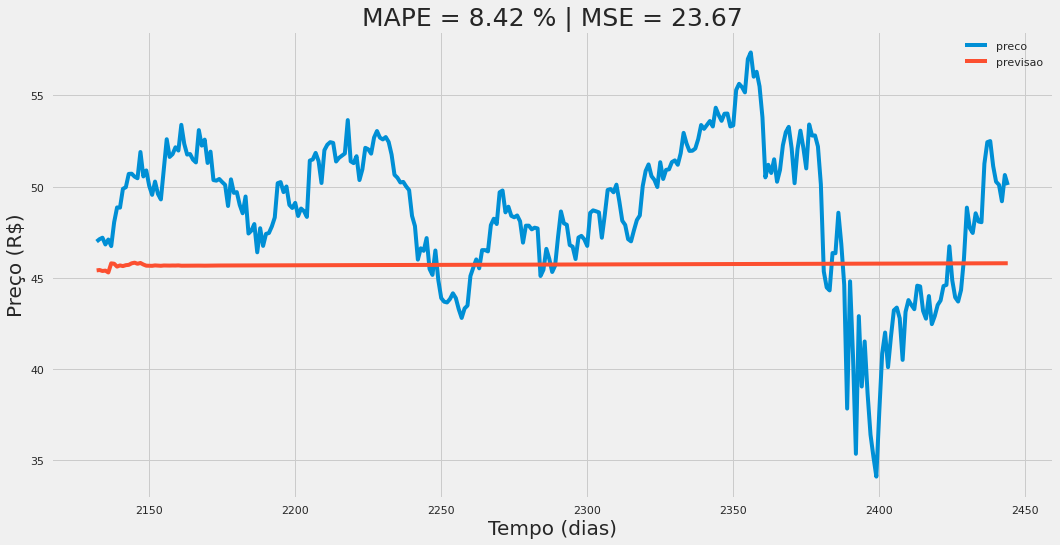

In [55]:
show_result_model(df_train=df_test,
                  df_test=df_test,
                  y_forecast=y_forecast_sarima,
                  model_name='sarima_model')

---

## Resultados

In [48]:
dict_results

{'ar_model': [7.955813872394689, 21.780365013206687],
 'arima_model': [8.514572215444968, 24.220464782643145],
 'sarima_model': [9.535109047752895, 33.967392880412575]}

---